The goal here is to follow this tutorial 

https://docs.pymc.io/notebooks/GLM-rolling-regression.html

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

In [2]:
import os

In [3]:
GAMMA = 1/4

I didn't know how to do this in python, so I just exported this data frame from R. 
It is a "rolling window" of cumulative cases (with the window = 20).

You can find it here: https://github.com/tvladeck/covid-rt/blob/pymc3-approach/nyc-series.csv

In [70]:
nyc = pd.read_csv('~/Repos/covid-rt/nyc-series.csv')
nyc_shutdown = pd.read_csv('~/Repos/covid-rt/shutdown-series.csv')

In [78]:
nycp1 = nyc[1:len(nyc)]
nycm1 = nyc[0:(len(nyc)-1)]
nycsd = nyc_shutdown

In [105]:
with pm.Model() as model_randomwalk:
    
    serial_interval = pm.Gamma('serial_interval', mu = 4, sd = 1)
    
    gamma = pm.Deterministic('gamma', 1/serial_interval)
    
    sigma_intercept = pm.HalfNormal('sigma_intercept', sd = 0.1)

    intercept = pm.GaussianRandomWalk('intercept', sd=sigma_intercept,
                                  shape=len(nycp1.nyc))
    
    beta = pm.Normal('beta', mu = -1, sd = 1)
    
    effect_of_shutdown = pm.Deterministic('effect_of_shutdown', beta * nycsd.shutdown)
    
    theta = pm.Deterministic('theta', intercept + effect_of_shutdown)
    
    rt = pm.Deterministic('rt', theta/gamma + 1)
    
    likelihood = pm.Poisson('y', mu = np.exp(theta) * nycm1.nyc, observed = nycp1.nyc)

In [106]:
with model_randomwalk:
    trace_rw = pm.sample(tune=1000, cores=2,
                         target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, sigma_intercept, serial_interval]
Sampling 2 chains: 100%|██████████| 3000/3000 [02:51<00:00,  7.45draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8951788332778514, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


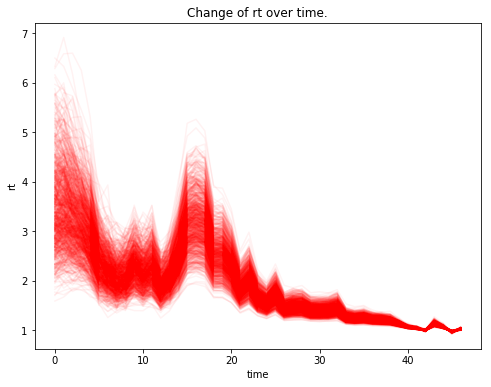

In [107]:
rt = trace_rw['rt'].T 
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, xlabel='time', ylabel='rt', title='Change of rt over time.')
ax.plot(rt, 'r', alpha=.05);

In [108]:
ppc = pm.sample_ppc(trace_rw, samples=500, model=model_randomwalk)

100%|██████████| 500/500 [00:00<00:00, 1772.93it/s]


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


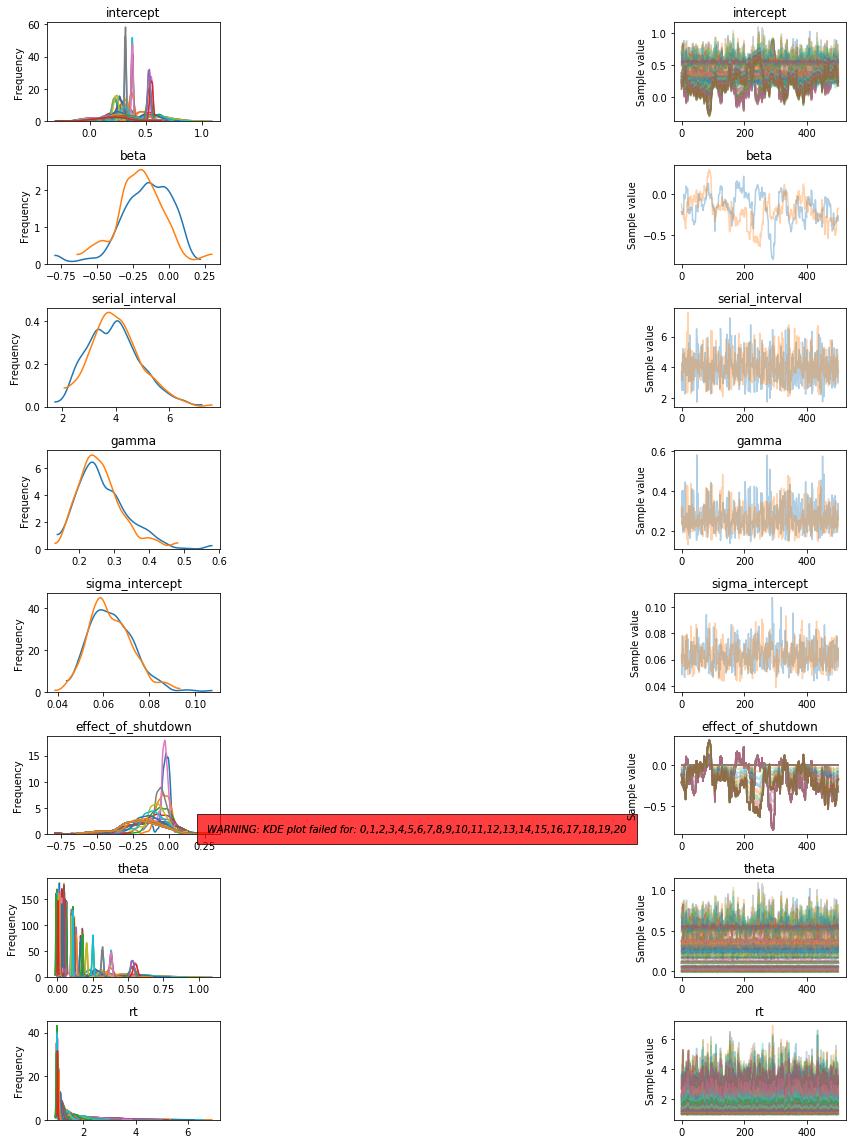

In [109]:
pm.traceplot(trace_rw);

In [110]:
trace_rw['beta'].mean()

-0.17845619887720457

In [111]:
trace_rw['beta'].var() ** (1/2)

0.17374815480459244